# Lab 06 : Image Data Modeling


#### Lab Overview

This workshop focuses on building a machine learning model that is able to classify images using neural networks.


#### Dataset Loading

**Definition:**
Organize your images into class-named subfolders and use TensorFlow’s high-level API to load, resize, batch, and normalize them for training.

**Directory Structure:**

```
data/
├── train/
│   ├── class_a/
│   │   ├── img001.jpg
│   │   └── img002.jpg
│   └── class_b/
│       ├── img101.jpg
│       └── img102.jpg
├── validation/
│   ├── class_a/
│   └── class_b/
└── test/
    ├── class_a/
    └── class_b/
```

**Loading the images from directory**

```python
import tensorflow as tf

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'directory path',
    labels=,
    label_mode=,
    image_size=,
    batch_size=,
    shuffle=,
    seed=42
)

```

**Explanation of Key Parameters:**

- **`directory`**: Root path containing class subfolders. ex: `data/train` in case of loading training dataset
- **`labels='inferred'`**: Automatically assign labels based on subfolder names.
- **`label_mode`**:

  - `'categorical'` → one-hot vectors,
  - `'int'` → integer indices,
  - `'binary'` → single 0/1 label (for 2-class problems).

- **`image_size=(H, W)`**: Resize each image to this shape. (based on model and image resolution)
- **`batch_size`**: How many images to return per batch (affects training speed/memory).
- **`shuffle` & `seed`**: Randomize sample order; seed ensures reproducibility. Usually shuffle is `True` for training and `False` for testing and validation.


#### Data Augmentation

**Definition:**
Dynamically apply random transformations to your training images to increase dataset diversity and help your model generalize.

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Configure augmentation parameters
gen = ImageDataGenerator(
    rotation_range=30,            # Random rotations in the range ±30°
    width_shift_range=0.1,        # Horizontal shifts up to 10% of image width
    height_shift_range=0.1,       # Vertical shifts up to 10% of image height
    brightness_range=[0.8, 1.2],  # Random brightness adjustments between 80% and 120%
    horizontal_flip=True,         # Randomly flip images left ↔ right
    zoom_range=0.2,               # Random zoom in range [80%, 120%]
    shear_range=0.1               # Shear intensity (in radians) up to ±0.1
)

# 2. Build an iterator that reads from directory and applies augmentations
iterator = gen.flow_from_directory(
    'data/train',                 # Root directory containing subfolders per class
    target_size=(224, 224),       # Resize all images to 224×224
    batch_size=32,                # Number of images per batch
    class_mode='categorical'      # Return one-hot encoded labels (use 'binary' for 2 classes)
)
```

**Explanation of Key Parameters:**

- `rotation_range`: Degree range for random rotations.
- `width_shift_range` & `height_shift_range`: Fraction of total width/height for random translations.
- `brightness_range`: Tuple `[min, max]` to scale pixel intensity.
- `horizontal_flip`: Boolean to enable random left–right flips.
- `zoom_range`: Float or `[min, max]` for random zoom.
- `shear_range`: Shear angle in radians for affine transformations.
- `flow_from_directory`:

  - **`'data/train'`**: folder with subdirectories named by class.
  - **`target_size`**: uniformly resizes input images.
  - **`batch_size`**: number of samples per generated batch.
  - **`class_mode`**: how labels are returned (`'categorical'`, `'binary'`, `'sparse'`, or `None`).


#### CNN Architecture in Keras

to get layers to build the architectural blocks of the CNN you need the following import:

`from tensorflow.keras import layers`

Break your model into two logical parts:

---

##### 1. Feature Extraction Block

**Definition:** Stacks of convolutional filters + downsampling to learn spatial hierarchies of features (edges → textures → shapes).

| Layer                  | Purpose & When to Use                                                           | Syntax Example                                                                         |
| ---------------------- | ------------------------------------------------------------------------------- | -------------------------------------------------------------------------------------- |
| **Conv2D**             | Learn local patterns; start with small filters (3×3) and double filters deeper. | `layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3))` |
| **BatchNormalization** | Stabilize and accelerate training by normalizing activations.                   | `layers.BatchNormalization()`                                                          |
| **Activation**         | Apply non-linearity (if not in Conv2D).                                         | `layers.Activation('relu')`                                                            |
| **MaxPooling2D**       | Downsample spatial dimensions by taking max in each region.                     | `layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))`                                  |
| **Dropout**            | Regularize; randomly zero inputs to reduce overfitting.                         | `layers.Dropout(0.25)`                                                                 |

**Typical order in one block:**

```python
layers.Conv2D(...)
layers.BatchNormalization()
layers.Activation('relu')        # or use activation in Conv2D
layers.MaxPooling2D(...)
layers.Dropout(0.25)
```

---

##### 2. Classification Block

**Definition:** Map flattened feature maps to class probabilities via dense layers.

| Layer                               | Purpose & When to Use                                              | Syntax Example                                    |
| ----------------------------------- | ------------------------------------------------------------------ | ------------------------------------------------- |
| **Flatten**                         | Collapse spatial dims to 1D vector                                 | `layers.Flatten()`                                |
| **GlobalAveragePooling2D** _(alt.)_ | Reduce each feature map to its average; fewer params than Flatten. | `layers.GlobalAveragePooling2D()`                 |
| **Dense**                           | Fully-connected layer to learn combinations of features.           | `layers.Dense(128, activation='relu')`            |
| **Dropout**                         | Further regularization before final output.                        | `layers.Dropout(0.5)`                             |
| **Output Dense (multi-class)**      | Final logits → probabilities across N classes.                     | `layers.Dense(num_classes, activation='softmax')` |
| **Output Dense (binary)**           | Single probability for two classes.                                | `layers.Dense(1, activation='sigmoid')`           |

**Typical order:**

```python
layers.Flatten()                     # or GlobalAveragePooling2D()
layers.Dense(128, activation='relu')
layers.Dropout(0.5)
layers.Dense(num_classes, activation='softmax')
```

To connect layers you put the output of the previous layer as the input of the current layer, example:

```python
input = keras.Input(shape=input_shape)
model = layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3))(input)
model = layers.Flatten()(model)
```

To get the whole model's architecture use the following: `model.summary()`


#### Model Training

**Definition:**
Compile your CNN by specifying the optimizer, loss, and metrics, then train it on your datasets using `model.fit()` without any callbacks.

```python
# 1. Compile the model
model.compile(
    optimizer='adam',                  # e.g. 'adam', 'sgd', or a configured tf.keras.optimizers.Optimizer
    loss='categorical_crossentropy',   # for one-hot multi-class; use 'binary_crossentropy' for 2-class
    metrics=['accuracy']               # list of metrics to track during training
)

# 2. Train the model
history = model.fit(
    train_ds,                          # tf.data.Dataset (or NumPy arrays) for training
    validation_data=val_ds,           # tf.data.Dataset (or tuple) for validation
    epochs=30                          # number of full passes through the training data
)
```

**Explanation of Key Arguments:**

- **`optimizer`**: algorithm that updates network weights (e.g., Adam adapts learning rates per parameter).
- **`loss`**: objective function to minimize; chosen based on label encoding (categorical vs. binary).
- **`metrics`**: additional performance measures displayed each epoch.
- **`train_ds`**: your preprocessed and batched training dataset.
- **`validation_data`**: held-out dataset to track generalization at the end of each epoch.
- **`epochs`**: how many times the model sees the entire training set.

The returned `history` object contains `history.history['loss']`, `['accuracy']`, `['val_loss']`, and `['val_accuracy']`, which you can plot to visualize training dynamics.


#### Model Evaluation

**Definition:**
Assess the trained model’s performance on held-out test data by computing loss and metrics, and (optionally) generating detailed reports like confusion matrices.

```python
# 1. Compute loss & accuracy on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
```

```python
# 2. (Optional) Detailed classification metrics
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Gather true labels and predictions
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_idx = np.argmax(y_true, axis=1)

# Print confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_true_idx, y_pred))
print("\nClassification Report:")
print(classification_report(y_true_idx, y_pred, target_names=test_ds.class_names))
```

**Explanation of Key Steps:**

- **`model.evaluate(test_ds)`**:

  - Runs the model on each batch in `test_ds`.
  - Returns the loss and any metrics (e.g., accuracy) defined at compile time.

- **`model.predict(test_ds)`**:

  - Generates raw predictions (probabilities) for each test sample.

- **`np.argmax(...)`**:

  - Converts one-hot or probability vectors to class indices.

- **`classification_report` / `confusion_matrix`**:

  - From scikit-learn, provides precision/recall/F1 for each class and a matrix of true vs. predicted labels.


#### Hands-on Activity

For the assigned dataset perform the following tasks:<br>
**Task 1** : Structure your directory as shown in the Dataset Loading section<br>
**Task 2** : Load the dataset and split it into training, validation, and test sets<br>
**Task 3** : Create a new directory containing four subdirectories—one for each class<br>
**Task 4** : Build the model architecture (feature-extraction and classification blocks), explaining your design choices as needed<br>
**Task 5** : Plot the training curves (e.g., loss and accuracy) and assess whether the model is overfitting or underfitting<br>
**Task 6** : Evaluate the final model on the test set and interpret the results<br>
**Task 7** : Choose a preprocessing technique from the previous lab, apply it to your images, then repeat Tasks 1–6 on the preprocessed dataset. Discuss whether performance improved or declined—and why.<br>


In [ ]:
#task 1 and 3 done

In [19]:
#libraries

import tensorflow as tf
from tensorflow.keras import layers, models
import os
import shutil
from glob import glob
import matplotlib.pyplot as plt
import cv2
import random



In [11]:
#task 2.1

# Set up paths
src_dir = 'processed_images'
dst_root = 'dataLab6'
splits = ['train', 'test', 'valid']
split_ratio = [0.7, 0.15, 0.15]

os.makedirs(dst_root, exist_ok=True)

for class_name in sorted(os.listdir(src_dir)):
    class_path = os.path.join(src_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = sorted(glob(os.path.join(class_path, '*')))
    total = len(images)
    n_train = int(total * split_ratio[0])
    n_test = int(total * split_ratio[1])
    n_valid = total - n_train - n_test


    train_images = images[:n_train]
    test_images = images[n_train:n_train + n_test]
    valid_images = images[n_train + n_test:]

    split_images = [train_images, test_images, valid_images]

    for split, imgs in zip(splits, split_images):
        split_class_dir = os.path.join(dst_root, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img_path in imgs:
            shutil.copy(img_path, split_class_dir)

print("Done splitting and copying images!")


Done splitting and copying images!


In [6]:
#task 2.2

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'dataLab6/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',  # For multi-class classification
    shuffle=True,
    seed=SEED
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    'dataLab6/valid',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'dataLab6/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)


Found 558 files belonging to 5 classes.
Found 122 files belonging to 5 classes.
Found 119 files belonging to 5 classes.


In [ ]:
#task 4.1
model = models.Sequential()

# Normalization layer
model.add(layers.Rescaling(1./255, input_shape=(224, 224, 3)))  

# First convolutional block
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))

# Second convolutional block
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))

# Third Convolutional Block
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.3))

# Classification Block
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=40
)



Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 473ms/step - accuracy: 0.4391 - loss: 18.0769 - val_accuracy: 0.1066 - val_loss: 5.6284
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 487ms/step - accuracy: 0.6351 - loss: 3.8101 - val_accuracy: 0.0902 - val_loss: 13.0782
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 466ms/step - accuracy: 0.6560 - loss: 1.1688 - val_accuracy: 0.4426 - val_loss: 11.8071
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 464ms/step - accuracy: 0.7208 - loss: 0.8220 - val_accuracy: 0.4180 - val_loss: 17.8740
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 471ms/step - accuracy: 0.7852 - loss: 0.6931 - val_accuracy: 0.4508 - val_loss: 17.2073
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 473ms/step - accuracy: 0.7725 - loss: 0.6870 - val_accuracy: 0.4754 - val_loss: 16.5529
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 472ms/step - accuracy: 0.8131 - loss: 0.6012 - val_accuracy: 0.5082 - val_loss: 16.7675
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 476ms/step - accuracy: 0.8252 - loss: 0.6379 - val_accu

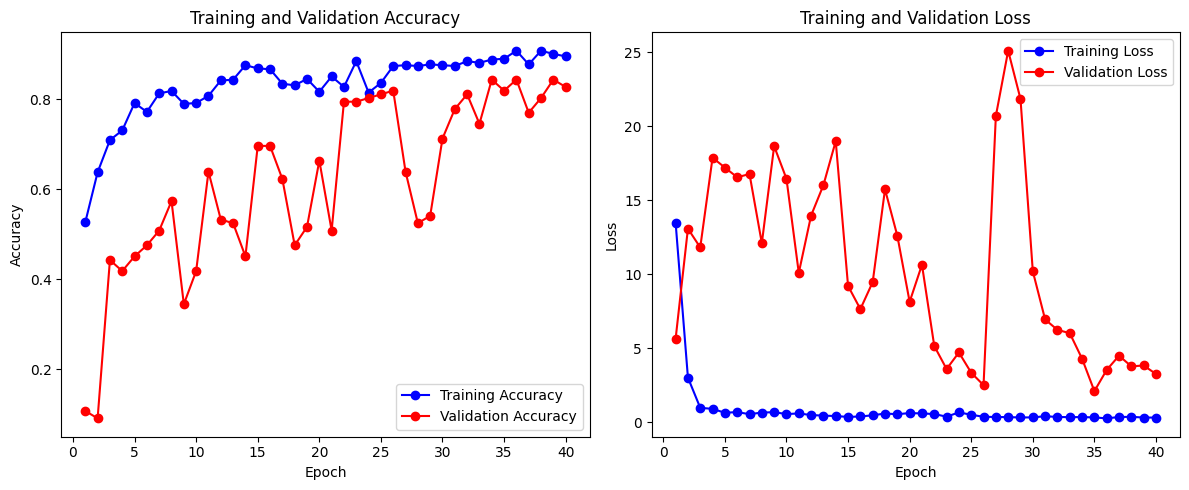

In [16]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


task 5 assessing overfitting
since training and validation accuracy are relatively close we have very little to no overfitting noting that validation adn training losses kept decreasing together with a slight jump at epochs 28-30 and at 37, but then validation loss kept decreasing as the training loss decreased.
therefore it is safe to say that we don't have overfitting.

assessing underfitting
since both training and validation accuracies are high and kept improving while epochs increased we can say that we also don't have underfitting.

Therefore, our model is Well Fit

In [ ]:
#task 6
test_loss, test_acc = model.evaluate(test_data)
print('Test accuracy:', test_acc)

#this indicates that the model is well trained and is generalizing well since it is giving test accuracy
#even higher than that of the validation accuracy
# low test loss indicates that the model is confident

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9121 - loss: 0.4060  
Test accuracy: 0.8739495873451233


In [20]:
#task 7, apply histogram equalization then do the same code as above

input_root = 'processed_images'  
output_root = 'processed_images_heq'   

os.makedirs(output_root, exist_ok=True)

for class_name in os.listdir(input_root):
    class_in = os.path.join(input_root, class_name)
    class_out = os.path.join(output_root, class_name)
    os.makedirs(class_out, exist_ok=True)

    for img_name in os.listdir(class_in):
        img_path = os.path.join(class_in, img_name)
        img = cv2.imread(img_path)
        if img is None: continue


        img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        img_ycrcb[:, :, 0] = cv2.equalizeHist(img_ycrcb[:, :, 0])
        img_eq = cv2.cvtColor(img_ycrcb, cv2.COLOR_YCrCb2BGR)

        cv2.imwrite(os.path.join(class_out, img_name), img_eq)

print("Preprocessing done!")


Preprocessing done!


In [21]:


src_dir = 'processed_images_heq'
dst_root = 'dataLab6_heq'
splits = ['train', 'test', 'valid']
split_ratio = [0.7, 0.15, 0.15]

os.makedirs(dst_root, exist_ok=True)

for class_name in sorted(os.listdir(src_dir)):
    class_path = os.path.join(src_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = sorted(glob(os.path.join(class_path, '*')))
    total = len(images)
    n_train = int(total * split_ratio[0])
    n_test = int(total * split_ratio[1])
    n_valid = total - n_train - n_test

    train_images = images[:n_train]
    test_images = images[n_train:n_train + n_test]
    valid_images = images[n_train + n_test:]
    split_images = [train_images, test_images, valid_images]

    for split, imgs in zip(splits, split_images):
        split_class_dir = os.path.join(dst_root, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img_path in imgs:
            shutil.copy(img_path, split_class_dir)

print("Dataset split complete!")


Dataset split complete!


In [22]:


BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'dataLab6_heq/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    'dataLab6_heq/valid',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'dataLab6_heq/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)


Found 558 files belonging to 5 classes.
Found 122 files belonging to 5 classes.
Found 119 files belonging to 5 classes.


In [23]:
model = models.Sequential()
model.add(layers.Rescaling(1./255, input_shape=(224, 224, 3)))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=40
)




Epoch 1/40


c:\Users\User\anaconda3\envs\data_analysis_env\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 470ms/step - accuracy: 0.4278 - loss: 22.0174 - val_accuracy: 0.2623 - val_loss: 3.7884
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 460ms/step - accuracy: 0.6818 - loss: 3.8478 - val_accuracy: 0.0656 - val_loss: 176.9010
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 455ms/step - accuracy: 0.7222 - loss: 2.4670 - val_accuracy: 0.0656 - val_loss: 298.0199
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 462ms/step - accuracy: 0.7611 - loss: 1.8295 - val_accuracy: 0.0656 - val_loss: 377.5354
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.7756 - loss: 0.9876 - val_accuracy: 0.0656 - val_loss: 399.9657
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 459ms/step - accuracy: 0.7762 - loss: 0.9739 - val_accuracy: 0.0656 - val_loss: 378.9252
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 465ms/step - accuracy: 0.7789 - loss: 0.9036 - val_accuracy: 0.0656 - val_loss: 372.4883
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 467ms/step - accuracy: 0.8168 - loss: 0.6782 - val_accuracy:

In [24]:
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8805 - loss: 0.5153
Test accuracy: 0.8992
Test loss: 0.4678


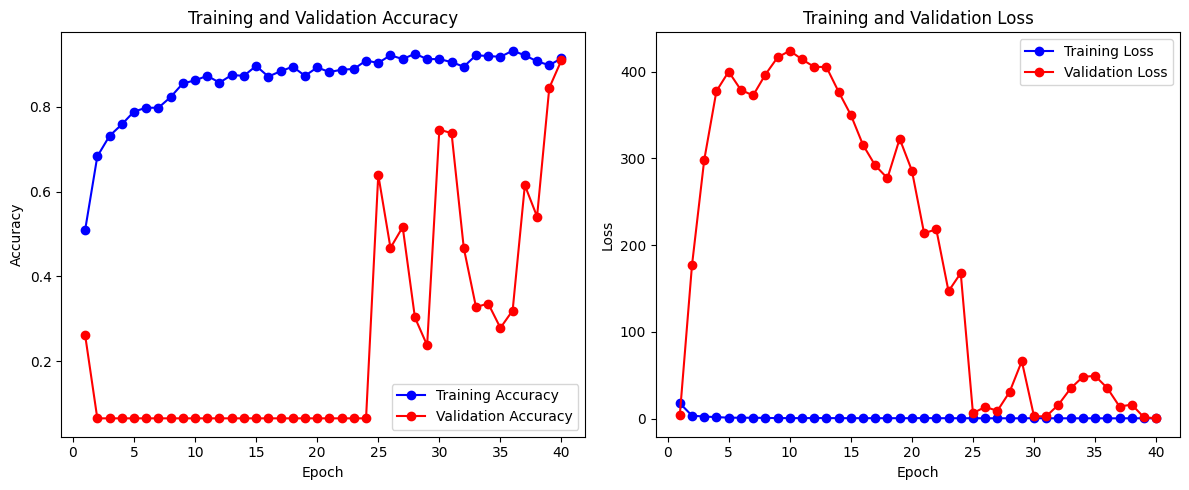

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Validation accuracy reached 91% and test accuracy reached 90%, both higher than that when we used data without histogram equalization

Training and validation curves are close, showing no overfitting as before.

Conclusion: Histogram equalization helped our model by making important contrast features more visible, allowing better class discrimination.